<a href="https://colab.research.google.com/github/valerialrc/ufv/blob/main/ELT575_Semana2_89397.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Importando dados

Aqui usaremos o dataset cifar10 (https://www.tensorflow.org/datasets/catalog/cifar10?hl=pt-br). O conjunto de dados CIFAR-10 consiste em 60.000 imagens coloridas 32x32 em 10 classes, com 6.000 imagens por classe. Existem 50.000 imagens de treinamento e 10.000 imagens de teste.

In [ ]:
# carregando dataset
(trainX, trainY), (testX, testY) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


Faremos algumas adequações para que os dados sejam usados no modelo de CNN. Basicamente, colocamos os valores dos pixels em uma escala de 0 a 1, visto que os valores originais dos pixels das imagens correspondem a uma escala de 0 a 255. Também transformamos nossa variável alvo em uma codificação one-hos

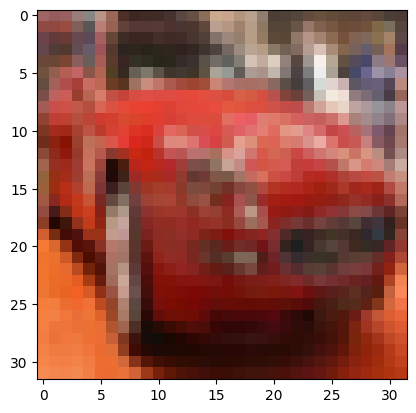

In [ ]:
plt.imshow(trainX[5]);

In [ ]:
# fazendo um reshape no dataset para ter um único canal
trainX = trainX.reshape((trainX.shape[0], 32, 32, 3))
testX = testX.reshape((testX.shape[0], 32, 32, 3))

# Convertendo valores dos pixels em float
trainX = trainX.astype('float32')
testX = testX.astype('float32')

# normalização para escala [0-1]
trainX = trainX / 255.0
testX = testX / 255.0

# transformando a variável alvo (target) para uma codificação one hot
trainY = to_categorical(trainY)
testY = to_categorical(testY)

# Construindo o modelo

O modelo usado será bem simples:
* Uma única camada convolucional com 32 filtros de tamanho 3 x 3 e função de ativação ReLU
* Camada MaxPooling para redução de dimensionalidade
* Transformação do resultado em um vetor
* Camada totalmente conectada com 100 neurônios e função de ativação ReLU
* Camada de saída softmax para estimar a probabilidade da entrada da rede pertencer a cada uma das 10 classes (dígitos 0 a 9)


Para treinamento do modelo, usaremos o algoritmo de otimização clássico do gradiente descendente estocástico (SDG), com a função objetiva como a entropia cruzada categórica. Nossa principal métrica de desempenho será a acurácia

In [ ]:
# definindo modelo
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # compilando modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# Treinamento do modelo

O treinamento será realizado usando o método da validação cruzada k-partições (k-fold) com k=5. Tal validação cruzada faz a divisão dos dados em 5 grupos de tamanho igual, sendo realizadas 5 treinamentos distintos. A cada treinamento, 4 grupos de dados são utilizados para treinar o modelo e o grupo remanescente é usado para teste do desempenho do modelo treinado.



* O principal intuito da validação k-fold é acessar a incerteza do desempenho do modelo

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Epoch 1/10
1250/1250 [==============================] - 60s 47ms/step - loss: 1.3673 - accuracy: 0.5200 - val_loss: 1.3912 - val_accuracy: 0.5341
Epoch 2/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.9948 - accuracy: 0.6515 - val_loss: 1.0818 - val_accuracy: 0.6242
Epoch 3/10
1250/1250 [==============================] - 56s 45ms/step - loss: 0.7951 - accuracy: 0.7200 - val_loss: 1.1190 - val_accuracy: 0.6236
Epoch 4/10
1250/1250 [==============================] - 58s 47ms/step - loss: 0.6202 - accuracy: 0.7836 - val_loss: 1.3247 - val_accuracy: 0.5996
Epoch 5/10
1250/1250 [==============================] - 54s 43ms/step - loss: 0.4695 - accuracy: 0.8368 - val_loss: 1.5421 - val_accuracy: 0.6016
Epoch 6/10
1250/1250 [==============================] - 56s 45ms/step - loss: 0.3502 - accuracy: 0.8793 - val_loss: 1.6341 - val_accuracy: 0.6007
Epoch 7/10
1250/1250 [==============================] - 54s 43ms/step - loss: 0.2632 - accuracy: 0.9085 - val_loss: 1.8909 -

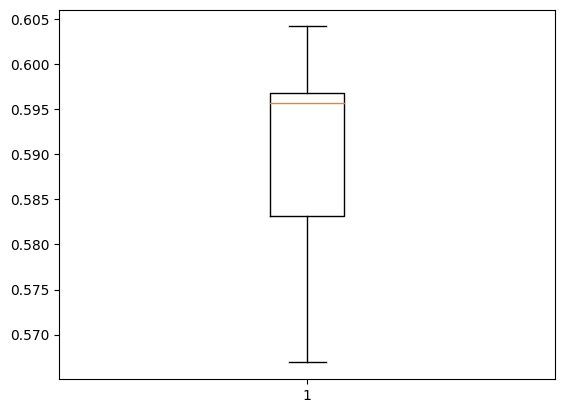

In [ ]:
scores = []
histories = []

# definindo a validação k-fold
kfold = KFold(5, shuffle=True, random_state=1)

# loop para as k-folds (cada fold usa subconjuntos de treino e teste diferentes)
for train_ix, test_ix in kfold.split(trainX):

  model = define_model()

  # recorta dados de acordo com índices da k-fold
  train_data, train_target, val_data, val_target = trainX[train_ix], trainY[train_ix], trainX[test_ix], trainY[test_ix]

  # treinamento do modelo
  history = model.fit(train_data, train_target,
                      epochs=10, batch_size=32,
                      validation_data=(val_data, val_target),
                      verbose=1)

  # desempenho do modelo
  _, acc = model.evaluate(val_data, val_target, verbose=0)
  print('> %.3f' % (acc * 100.0))

  # armazena resultados de cada modelo treinado dentro da k-fold
  scores.append(acc)
  histories.append(history)

print('Acurácia: média=%.3f desvio=%.3f' % (np.mean(scores)*100, np.std(scores)*100))
plt.boxplot(scores)
plt.show()

# Testando modelo no conjunto de teste

Agora avaliaremos o desempenho do modelo em dados do conjunto de teste separado nas etapas iniciais deste exercício
* Abaixo temos a primeira imagem do conjunto de teste

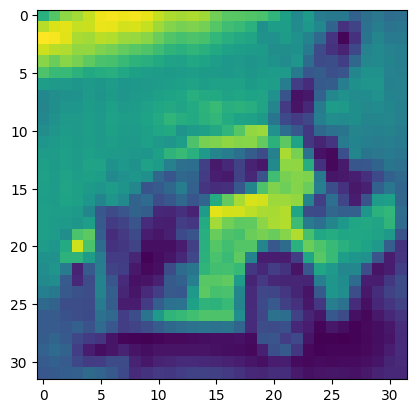

In [ ]:
plt.imshow(testX[6,:,:,0]);

Usaremos o último modelo treinado na validação cruzada k-fold para classificar a imagem.

* temos que fazer uma expansão de dimensão para que nossa imagem tenha um formato 1 x 32 x 32 x 3. Isso é necessário pois treinamos nosso modelo usando mini conjuntos de imagens (como nosso batch size era de 32, o formato passado para o modelo a cada passo de treinamento era 32 x 32 x 32 x 3)

In [ ]:
np.argmax(model.predict(np.expand_dims(testX[6], axis=0)))

1/1 [==============================] - 0s 122ms/step


1

Utilizando exatamente a mesma rede do exemplo os resultados foram:
  
  - Acurácia: média=58.936 desvio=1.310

No banco de dados do exemplo, a acurácia média foi de aproximadamente 98, um resultado muito superior, o que indica que a rede se comporta melhor com dados com as características dos do exemplo do que com os propostos pelo exercício.

### Agora, adicionando mais dois blocos de camadas Conv2D (64 filtros 3x3 - relu) + MaxPooling (2 x 2) antes da camada Flatten.

In [ ]:
# definindo modelo
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # compilando modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Treinando o modelo novamente

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Epoch 1/10
1250/1250 [==============================] - 80s 63ms/step - loss: 1.4410 - accuracy: 0.4806 - val_loss: 1.2338 - val_accuracy: 0.5611
Epoch 2/10
1250/1250 [==============================] - 78s 63ms/step - loss: 1.0929 - accuracy: 0.6143 - val_loss: 1.0489 - val_accuracy: 0.6287
Epoch 3/10
1250/1250 [==============================] - 80s 64ms/step - loss: 0.9421 - accuracy: 0.6698 - val_loss: 1.1014 - val_accuracy: 0.6159
Epoch 4/10
1250/1250 [==============================] - 83s 66ms/step - loss: 0.8464 - accuracy: 0.7041 - val_loss: 0.8918 - val_accuracy: 0.6875
Epoch 5/10
1250/1250 [==============================] - 78s 62ms/step - loss: 0.7718 - accuracy: 0.7307 - val_loss: 0.9572 - val_accuracy: 0.6677
Epoch 6/10
1250/1250 [==============================] - 82s 66ms/step - loss: 0.7084 - accuracy: 0.7508 - val_loss: 1.0170 - val_accuracy: 0.6609
Epoch 7/10
1250/1250 [==============================] - 78s 62ms/step - loss: 0.6519 - accuracy: 0.7708 - val_loss: 0.9285 -

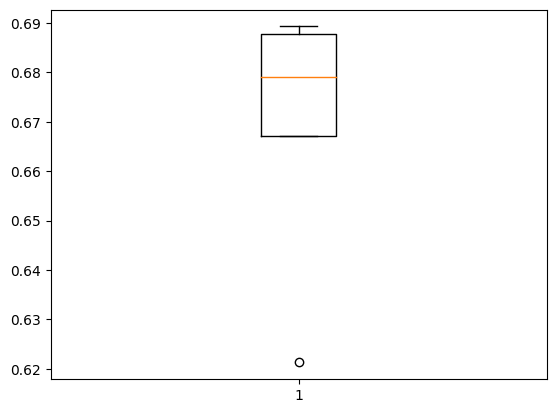

In [ ]:
scores = []
histories = []

# definindo a validação k-fold
kfold = KFold(5, shuffle=True, random_state=1)

# loop para as k-folds (cada fold usa subconjuntos de treino e teste diferentes)
for train_ix, test_ix in kfold.split(trainX):

  model = define_model()

  # recorta dados de acordo com índices da k-fold
  train_data, train_target, val_data, val_target = trainX[train_ix], trainY[train_ix], trainX[test_ix], trainY[test_ix]

  # treinamento do modelo
  history = model.fit(train_data, train_target,
                      epochs=10, batch_size=32,
                      validation_data=(val_data, val_target),
                      verbose=1)

  # desempenho do modelo
  _, acc = model.evaluate(val_data, val_target, verbose=0)
  print('> %.3f' % (acc * 100.0))

  # armazena resultados de cada modelo treinado dentro da k-fold
  scores.append(acc)
  histories.append(history)

print('Acurácia: média=%.3f desvio=%.3f' % (np.mean(scores)*100, np.std(scores)*100))
plt.boxplot(scores)
plt.show()

O resultado foi:

  - Acurácia: média=66.892 desvio=2.507

Adicionar mais camadas convolucionais e de pooling permite que o modelo aprenda representações hierárquicas mais complexas das imagens, o que pode resultar em uma capacidade de generalização melhorada.

### Agora, adicionando um Dropout de 20% após cada camada MaxPooling.

In [ ]:
# definindo modelo
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # compilando modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Treinando o modelo novamente

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Epoch 1/10
1250/1250 [==============================] - 93s 73ms/step - loss: 1.5980 - accuracy: 0.4145 - val_loss: 1.4383 - val_accuracy: 0.4856
Epoch 2/10
1250/1250 [==============================] - 80s 64ms/step - loss: 1.3004 - accuracy: 0.5340 - val_loss: 1.2367 - val_accuracy: 0.5665
Epoch 3/10
1250/1250 [==============================] - 82s 66ms/step - loss: 1.1767 - accuracy: 0.5824 - val_loss: 1.4642 - val_accuracy: 0.5138
Epoch 4/10
1250/1250 [==============================] - 81s 65ms/step - loss: 1.0971 - accuracy: 0.6124 - val_loss: 1.1170 - val_accuracy: 0.6117
Epoch 5/10
1250/1250 [==============================] - 83s 66ms/step - loss: 1.0454 - accuracy: 0.6305 - val_loss: 0.9350 - val_accuracy: 0.6748
Epoch 6/10
1250/1250 [==============================] - 81s 65ms/step - loss: 1.0014 - accuracy: 0.6454 - val_loss: 0.9416 - val_accuracy: 0.6674
Epoch 7/10
1250/1250 [==============================] - 88s 71ms/step - loss: 0.9675 - accuracy: 0.6590 - val_loss: 0.9326 -

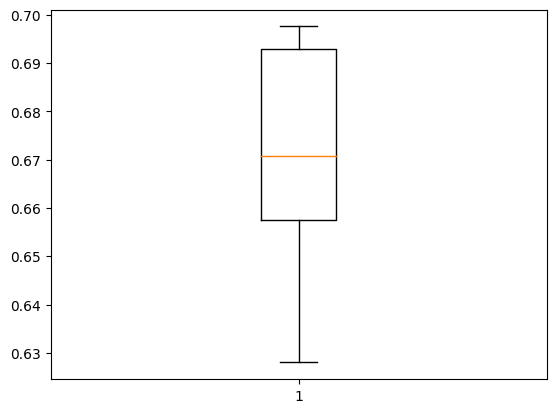

In [ ]:
scores = []
histories = []

# definindo a validação k-fold
kfold = KFold(5, shuffle=True, random_state=1)

# loop para as k-folds (cada fold usa subconjuntos de treino e teste diferentes)
for train_ix, test_ix in kfold.split(trainX):

  model = define_model()

  # recorta dados de acordo com índices da k-fold
  train_data, train_target, val_data, val_target = trainX[train_ix], trainY[train_ix], trainX[test_ix], trainY[test_ix]

  # treinamento do modelo
  history = model.fit(train_data, train_target,
                      epochs=10, batch_size=32,
                      validation_data=(val_data, val_target),
                      verbose=1)

  # desempenho do modelo
  _, acc = model.evaluate(val_data, val_target, verbose=0)
  print('> %.3f' % (acc * 100.0))

  # armazena resultados de cada modelo treinado dentro da k-fold
  scores.append(acc)
  histories.append(history)

print('Acurácia: média=%.3f desvio=%.3f' % (np.mean(scores)*100, np.std(scores)*100))
plt.boxplot(scores)
plt.show()

O resultado foi:

- Acurácia: média=66.940 desvio=2.533

Aplicar o dropout de 20% após cada camada de MaxPooling não resultou em diferenças significativas. Isso pode indicar que o modelo ainda não está passando por overfitting.